## Dados COVID19 em .ipynb  02/05/2020

        Estou tentando importar e utilizar os dados do Ministério da Saúde em
    https://covid.saude.org.br para avaliar a situação divulgada oficialmente
    pelo MS; A url muda diariamente, há uma série de caracteres em primeira
    vista aleatórios que é atualizada também todo dia... como puxar o arquivo
    csv automaticamente?
    
        O site não disponibiliza dados de SRAG, apenas uma tabela repetida e
        desatualizada do COVID19. 
    
        Nova tabela com dados do Brasil (população)
    
        Dados de SRAG da fiocruz estão no padrão brasileiro (109,0009) como
    transformar o arquivo em padrão americano/internacional (109.0009)
    automaticamente pela URL?

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado
        
            Mostrar dados de SRAG e comparar com o aumento dos números
            confirmados de COVID
        Dados em semana epidemiológica

## Estimativas (Regressão)
        
            Estimar próximos números (até 7 dias?) utilizando 3 dias anteriores
        e regressão não linear
        
            Estimar curvas com ajuda dos dados de SRAG inconclusivos (qual a 
        porcentagem de testes incompletos espera-se que serão confirmados)
        
## Modelo de Contágio

            Utilizar dados adquiridos para rodar um modelo epidemiológico que
        utiliza valores de reprodução base e evolução da COVID-19, causada
        pelo vírus SARS-COV-2
  

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

url_B = "https://raw.githubusercontent.com/Yannngn/COVID19-04-20/master/brasil.csv"
url_C = url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/42831846b6d7e37dd600253a81098f8a_Download_COVID19_20200502.csv"

In [2]:
brasil = pd.read_csv(url_B, sep = ';')
df = pd.read_csv(url_C, sep = ";")

In [3]:
FMT = '%Y-%m-%d'

date = df['data']
regi = df['regiao']

df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)


In [4]:
df = df.sort_values('estado')

df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos', 'estado']]
df_UF = df.loc[:, ['estado', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

In [5]:
df1 = df1.groupby("data").sum()

pBrasil = brasil.at[brasil['UF'].eq('BR').idxmax(),'População']

# total of days since 2020-01-30 - x
days = list(df1.index)
x = days

In [6]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return [a, b]

def exp_est (R, X) :
    np.random.seed(max(x))
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return a * np.exp(b * (max(x) + 1)) + norm.rvs(size = 1,scale = 0.05 * (max(x) + 1))

In [7]:
desc = ["Total cases", "New cases", "Total deaths", "New deaths"]

for i in range(4) :
    y = list(df1.iloc[:, i])
    d0 = int(3 * max(days) / 4)
    d1 = int(5 * max(days) / 6)
    
    exp_p = exp_param([y[d0], y[d1], y[-1]], [x[d0], x[d1], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 0])
    
    exponential_errors = [np.sqrt(exponential_fit[1][j][j]) for j in range(3)]
    print(desc[i] + " parameters are: \n")
    for j in range(3) :
        print(str(round(exponential_fit[0][j], 3)) + " +/- " + str(round(exponential_errors[j], 3)))
    print(" \n")

Total cases parameters are: 

130.518 +/- 21419890.954
0.079 +/- 0.001
8.537 +/- 2088313.597
 

New cases parameters are: 

641434.004 +/- 1.0966456049859848e+76
0.009 +/- 6.445580717167007e+60
17479.408 +/- 1.9919646621187326e+72
 

Total deaths parameters are: 

0.661 +/- 89600.901
0.088 +/- 0.001
-12.568 +/- 1543761.27
 

New deaths parameters are: 

2.323 +/- nan
0.072 +/- 0.004
18.581 +/- nan
 



## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [8]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

In [9]:
print("The errors of the logistic model parameters of: \n")

a0 = 1.2

lb = [max(days) + 14, max(days) + 31]


lc = [0.2 * pBrasil, 0.01 * pBrasil]

for i in range(2) :
    x = days
    y = list(df1.iloc[:, 2 * i])

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[i], lc[i]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
    
    logistic_errors = [np.sqrt(logistic_fit[1][j][j]) for j in [0, 1, 2]]
   
    print(desc[2 * i] + " numbers are: " + str(logistic_errors) + "\n")

The errors of the logistic model parameters of: 

Total cases numbers are: [0.25835686718541456, 1.7386571420608061, 26670.212741367774]

Total deaths numbers are: [0.21078443939400582, 1.1076157416914025, 1035.1535775262082]




# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

C:\Users\calad\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The expected final values: end of spread in 136 +/- 1.74 days, with 260695.942 +/- 26670.21 Confirmed COVID19 cases
Next estimated Confirmed COVID19 cases number is 107771.155


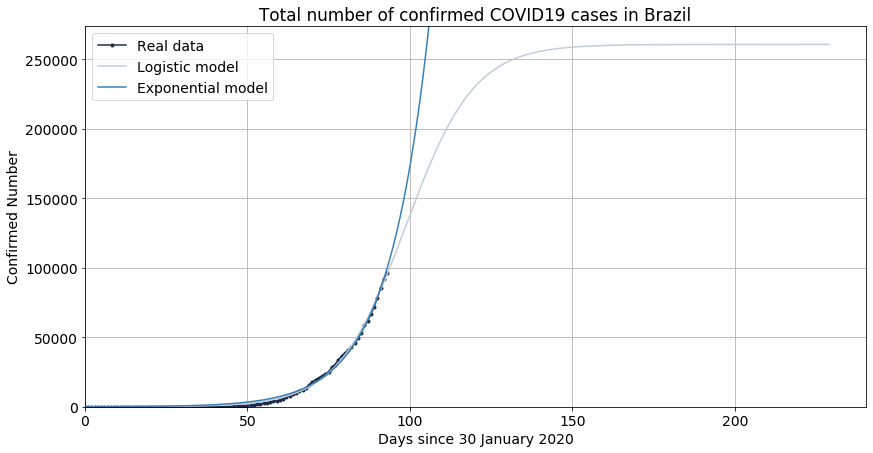

C:\Users\calad\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Next estimated New confirmed COVID19 cases number is 7091.712


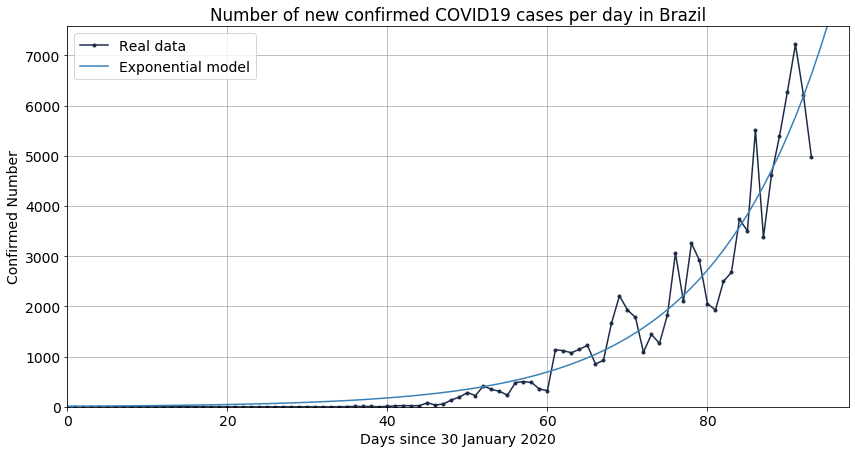

C:\Users\calad\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The expected final values: end of spread in 87 +/- 1.11 days, with 14496.682 +/- 1035.15 Deaths by COVID19
Next estimated Deaths by COVID19 number is 7713.06


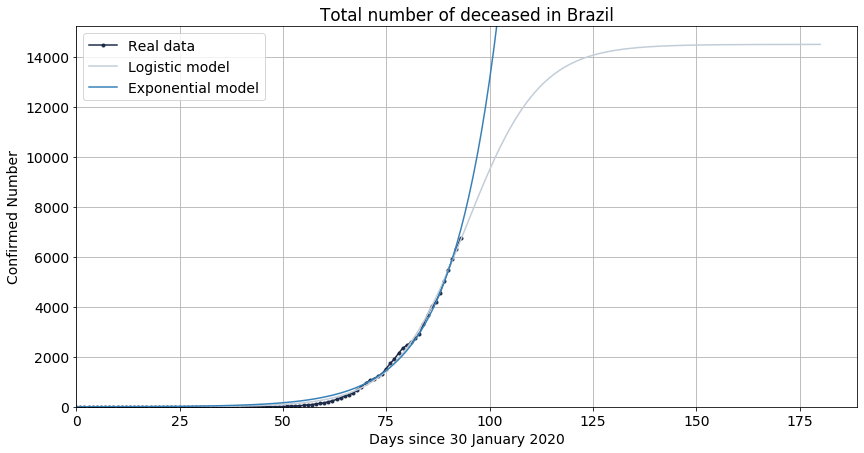

Next estimated New confirmed deaths number is -0.0


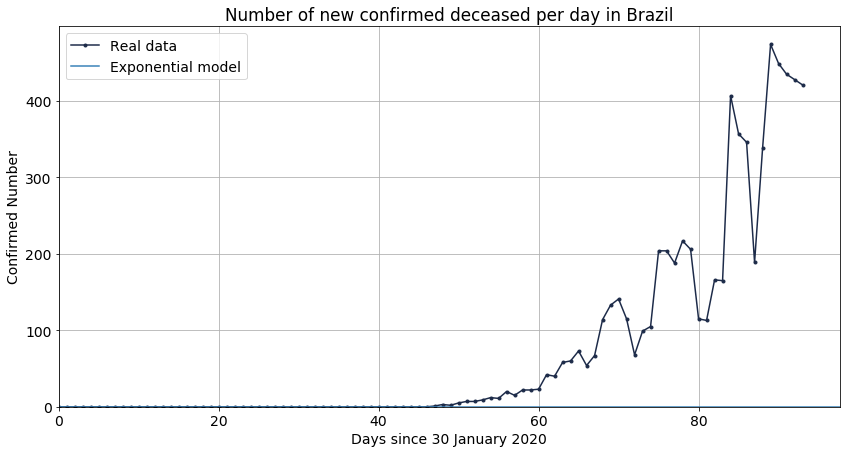

In [10]:
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]
ttl = ["Total number of confirmed COVID19 cases",
         "Number of new confirmed COVID19 cases per day",
         "Total number of deceased",
         "Number of new confirmed deceased per day"]
desc = ["Confirmed COVID19 cases",
         "New confirmed COVID19 cases",
         "Deaths by COVID19",
         "New confirmed deaths"]
expo = []

for f in range(4) :
    x = days
    plt.grid(True)
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 7]
    
    y = list(df1.iloc[:, f])
      
    exp_p = exp_param([y[-5], y[-3], y[-1]], [x[-5], x[-3], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] * np.exp(-1), exp_p[1], 1])
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                              exponential_fit[0][2]) - int(exponential_fit[0][2]),
                                 exponential_fit[0][1]))
    exponential_errors = [np.sqrt(exponential_fit[1][j][j]) for j in [0, 1, 2]]
    
    pred_x = list(range(max(x), max(x) + 15 ))

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")
    
    # Predicted logistic curve for the total data
    if (f == 0 or f == 2) :
        logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[int(f * 0.5)], lc[int(f * 0.5)]])
        logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], 
                                                            logistic_fit[0][1], logistic_fit[0][2])
                                  - int(logistic_fit[0][2]), logistic_fit[0][1]))
        
        logistic_errors = [np.sqrt(logistic_fit[1][j][j]) for j in [0, 1, 2]]
        
        pred_x = list(range(max(x), logistic_sol))
        
        plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                              for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
        print("The expected final values: end of spread in " + str(max(pred_x) - max(x))
              + " +/- " + str(round(logistic_errors[1], 2)) + " days, with " + str(round(logistic_fit[0][2], 3))
              + " +/- " + str(round(logistic_errors[2], 2)) + " " + desc[f])
        
    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")
    
    expo.append(exponential_fit)

    plt.title(ttl[f] + " in Brazil")
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Confirmed Number")
    
    if (f == 0 or f == 2) :
        plt.xlim(0, max(pred_x) * 1.05)
        plt.ylim(0, logistic_fit[0][2] * 1.05)
    else :
        plt.ylim(0, max(y) * 1.05)
        plt.xlim(0, max(x) * 1.05)
    print("Next estimated " + desc[f] + " number is " + 
          str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3)))
    plt.show()

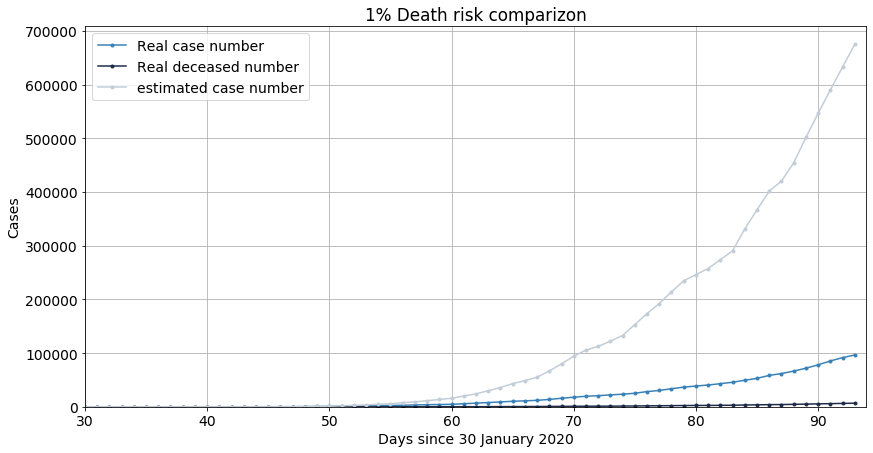

Expected actual value is: 675000 in day 93


In [11]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data

y = list(df1.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df1.iloc[:, 2])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df1.iloc[:, 2].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.xlim(30, max(x) * 1.01)
plt.ylim(0, max(y) * 1.05)
plt.show()
print("Expected actual value is: " + str(max(y)) + " in day " + str(max(x)))

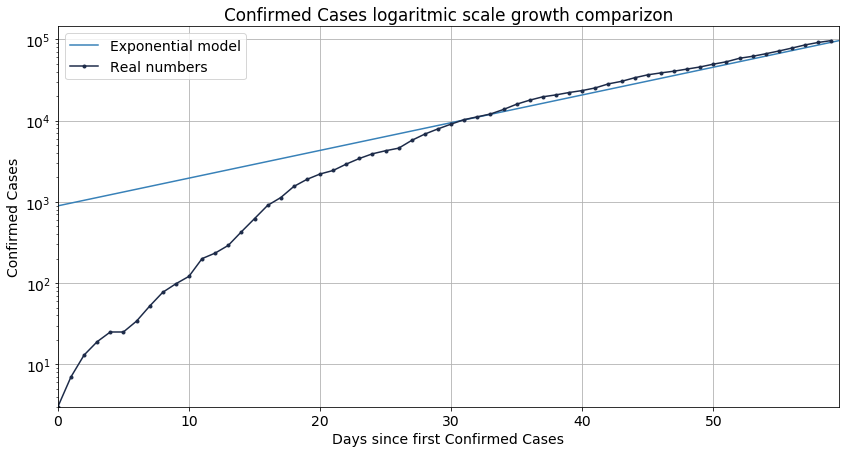

The growth rate of Confirmed Cases is: doubling every 9 days


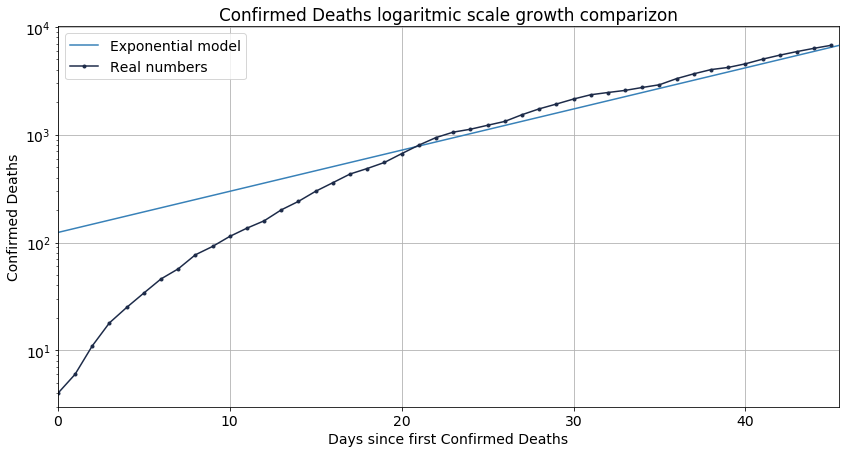

The growth rate of Confirmed Deaths is: doubling every 8 days


In [12]:
inicio = [33, 47]
ttl = ["Confirmed Cases", "Confirmed Deaths"]
for f in range(2) :
    plt.grid(True)
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 7]

    # Lines
    x = days
    y = list(df1.iloc[:, 2 * f])

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[f], lc[f]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]),
                              logistic_fit[0][1]))

    exp_p = exp_param([y[-4], y[-2], y[-1]], [x[-4], x[-2], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] - 1, exp_p[1], 1])

    pred_x = list(range(max(x), logistic_sol))

    plt.plot(x + pred_x, [exponential_model(i + inicio[f], exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                              for i in x + pred_x], label = "Exponential model", color = "#3881b8")

    # Real data

    x = list(df1.head(max(days) - inicio[f]).index)

    y = list(df1.iloc[:, 2 * f].tail(max(days) - inicio[f]))
    plt.plot(x, y, marker = '.', label = "Real numbers", color = "#1d2b49")

    plt.title(ttl[f] + " logaritmic scale growth comparizon")
    plt.legend()
    plt.yscale('log')
    plt.xlabel("Days since first " + ttl[f])
    plt.ylabel(ttl[f])
    plt.xlim(0, max(x) * 1.01)
    plt.ylim(3, max(y) * 1.5)
    plt.show()

    print("The growth rate of " + ttl[f] + " is: doubling every " + str(int(round(np.log(2) / exponential_fit[0][1], 0))) + " days")